In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = 'D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 1797 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 56 images belonging to 4 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = 'D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 604 images belonging to 4 classes.


In [7]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [8]:
# Freezing Layers

for layer in base_model.layers[:-8]:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [15]:
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/5
29/29 [==============================] - 1126s 39s/step - loss: 1.4544 - accuracy: 0.7186 - precision: 0.3343 - recall: 0.1269 - auc: 0.6052 - f1_score: 0.1779 - val_loss: 18.0267 - val_accuracy: 0.6607 - val_precision: 0.3214 - val_recall: 0.3214 - val_auc: 0.5634 - val_f1_score: 0.3214 - lr: 0.0010
Epoch 2/5
29/29 [==============================] - 1219s 42s/step - loss: 1.1185 - accuracy: 0.7720 - precision: 0.6396 - recall: 0.2014 - auc: 0.7644 - f1_score: 0.3141 - val_loss: 4.2405 - val_accuracy: 0.6607 - val_precision: 0.3214 - val_recall: 0.3214 - val_auc: 0.6042 - val_f1_score: 0.3214 - lr: 0.0010
Epoch 3/5
29/29 [==============================] - 1100s 38s/step - loss: 0.9348 - accuracy: 0.8126 - precision: 0.8233 - recall: 0.3189 - auc: 0.8562 - f1_score: 0.4615 - val_loss: 1.8500 - val_accuracy: 0.8125 - val_precision: 0.6750 - val_recall: 0.4821 - val_auc: 0.7884 - val_f1_score: 0.5625 - lr: 0.0010
Epoch 4/5
29/29 [==========

In [16]:
model.evaluate(test_dataset, verbose=1)

10/10 [==============================] - 207s 20s/step - loss: 49.0315 - accuracy: 0.7442 - precision: 0.4884 - recall: 0.4868 - auc: 0.6661 - f1_score: 0.4823


[49.031471252441406,
 0.7442052960395813,
 0.4883720874786377,
 0.4867549538612366,
 0.6661294102668762,
 0.4823343753814697]

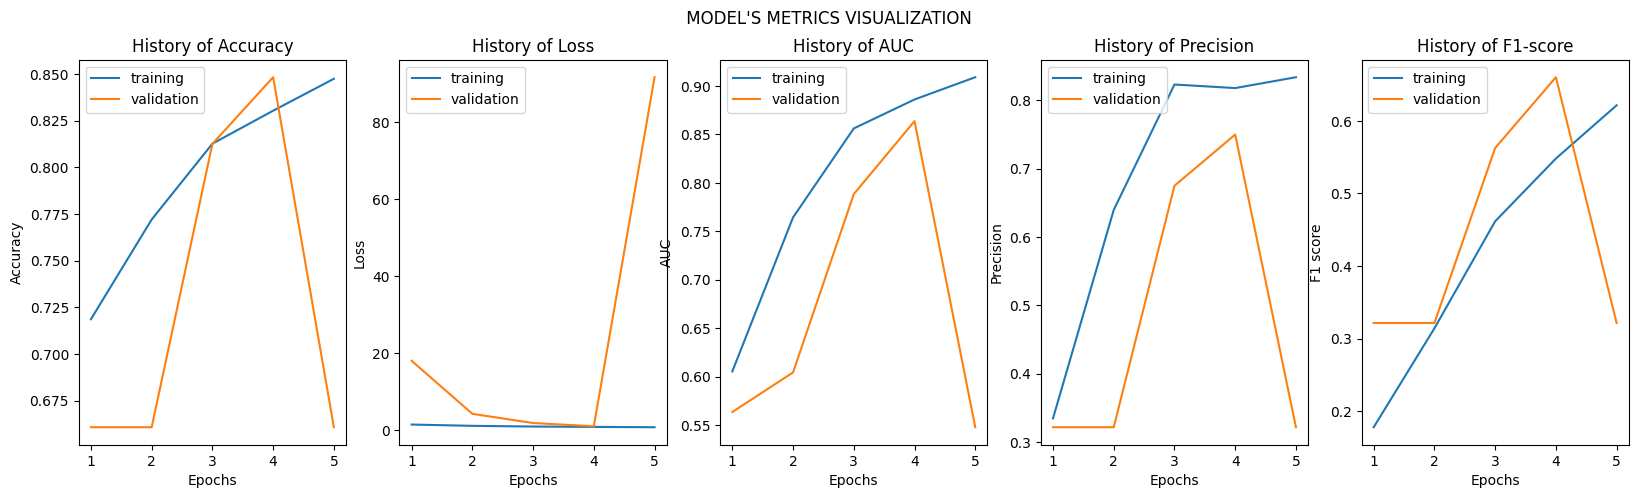

In [17]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
# 2. Test 

In [3]:
#import libraries
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from skimage import io
from skimage.color import rgb2gray
import plotly.express as px
import random
from sklearn.utils import shuffle
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.applications import resnet


import tensorflow_addons as tfa

#check tensorflow verison
tf.__version__

'2.11.0'

In [21]:
# set visualization defaults
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['xtick.color'] = 'dimgrey'
plt.rcParams['ytick.color'] = 'dimgrey'
plt.rcParams['axes.labelcolor'] = 'dimgrey'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [29]:
#get global path
global_dir = "D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/"
os.listdir(global_dir)

['test', 'train', 'valid']

In [30]:
# Set directories
test_dir = "D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/test"
train_dir = "D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train"
valid_dir = "D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid"

In [31]:
# train sets
for files in os.listdir(train_dir):
    print(os.path.join(train_dir,files))

print('\n')
# valid sets
for files in os.listdir(valid_dir):
    print(os.path.join(valid_dir,files))

print('\n')
# test sets
for files in os.listdir(test_dir):
    print(os.path.join(test_dir,files))

D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train\BANANA BACTERIAL WILT
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train\BANANA FUNGUS SIGATOKA
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train\BANANA STREAK VIRUS
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/train\HEALTHY


D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid\BANANA BACTERIAL WILT
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid\BANANA FUNGUS SIGATOKA
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid\BANANA STREAK VIRUS
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/valid\HEALTHY


D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/test\BANANA BACTERIAL WILT
D:/PHD/Journal Paper/SpringerPaper/Banana Disease Types/Code/Two/Data/test\BANANA FUNGUS SIGATOKA
D:/PHD/Journal Paper/SpringerPaper/Banana Disea

In [ ]:
# Model Building

In [32]:
#set globals
BATCH_SIZE = 32
EPOCHS = 100
SEED = 49
H = 300 #Height
W = 400 #Width
IMAGE_SHAPE = (460,460,3)
N_CLASSES = 4
STEPS = 50

In [33]:
# Setup GPU accelerator - configure Strategy
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) #Assume TPU
except ValueError:
    strategy = tf.distribute.get_strategy() #if not TPU, set default for GPU/CPU

In [34]:
train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 1797 images belonging to 4 classes.
Found 56 images belonging to 4 classes.


In [37]:
with strategy.scope(): #use TPU/GPU strategy
    
    res_model = ResNet50(include_top=False, 
                         pooling='avg', 
                         weights='imagenet', 
                         input_shape = (IMAGE_SHAPE))

    for layer in res_model.layers:
        if 'conv5' not in layer.name:
            layer.trainable = False

    resnet_model = Sequential()
    resnet_model.add(res_model)
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Flatten())
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Dense(N_CLASSES, activation='softmax'))
    resnet_model.summary()
#tf.keras.optimizers.legacy.Adam.
    adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001, decay= 1e-5)
    
    resnet_model.compile(optimizer=adam_optimizer, 
                         loss='categorical_crossentropy',
                         metrics=['accuracy']) #need to update to use f1 score too

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 8196      
                                                      

In [38]:
checkpoint = ModelCheckpoint(filepath='./transfer_model.hdf5', 
                               monitor='val_loss', 
                               verbose = 1,
                               save_best_only=True)

early_stopping = EarlyStopping(verbose=1, 
                               patience=2)

history_model = resnet_model.fit(train_generator,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_generator,
                               callbacks = [checkpoint, early_stopping])

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 1.2906 - accuracy: 0.5526 
Epoch 1: val_loss improved from inf to 0.61944, saving model to .\transfer_model.hdf5
57/57 [==============================] - 1466s 26s/step - loss: 1.2906 - accuracy: 0.5526 - val_loss: 0.6194 - val_accuracy: 0.7857
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8370 
Epoch 2: val_loss improved from 0.61944 to 0.43619, saving model to .\transfer_model.hdf5
57/57 [==============================] - 1411s 25s/step - loss: 0.4656 - accuracy: 0.8370 - val_loss: 0.4362 - val_accuracy: 0.8929
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8998 
Epoch 3: val_loss improved from 0.43619 to 0.33187, saving model to .\transfer_model.hdf5
57/57 [==============================] - 1345s 24s/step - loss: 0.3148 - accuracy: 0.8998 - val_loss: 0.3319 - val_accuracy: 0.8929
Epoch 4/100
57/57 [==============================]

In [39]:
#check keys before plotting
history_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

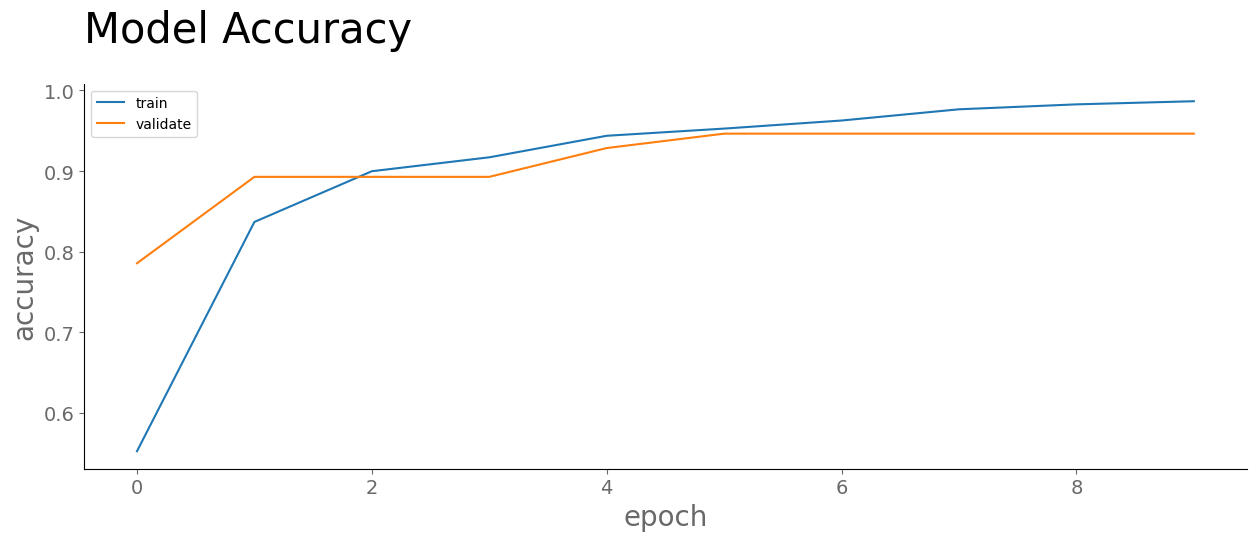

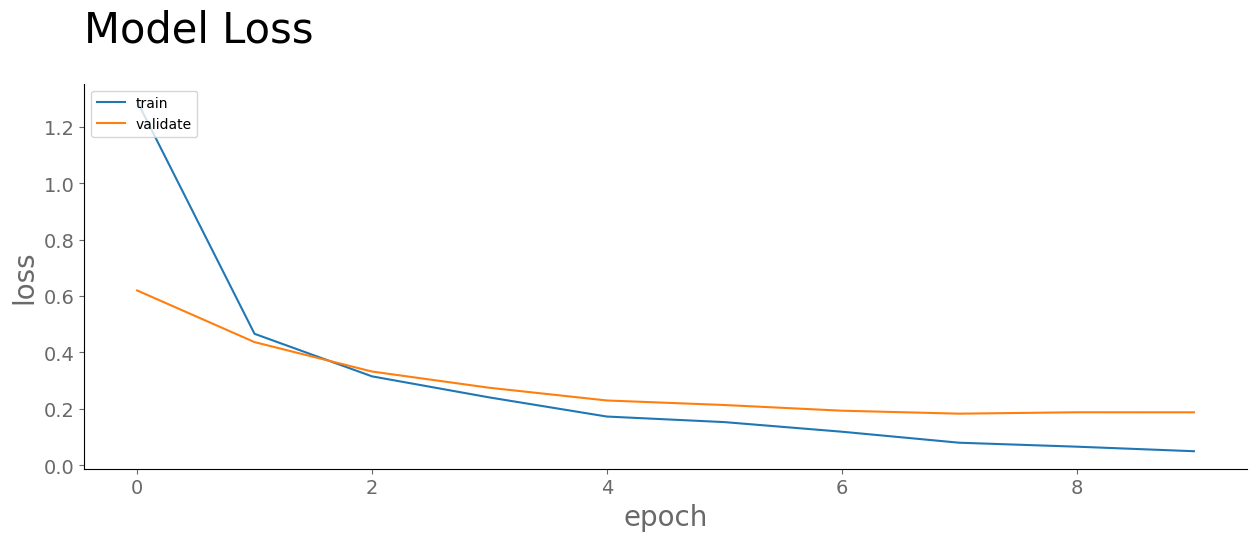

In [40]:
# graph accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [ ]:
# Fnet Abouve

In [ ]:
#3. Transfer Learning
# BNet Model

In [3]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

In [4]:
train_path = "Data/train"
valid_path = "Data/valid"
test_path = "Data/test"

In [5]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 1797 images belonging to 4 classes.
Found 56 images belonging to 4 classes.
Found 604 images belonging to 4 classes.


['BANANA BACTERIAL WILT', 'BANANA FUNGUS SIGATOKA', 'BANANA STREAK VIRUS', 'HEALTHY']


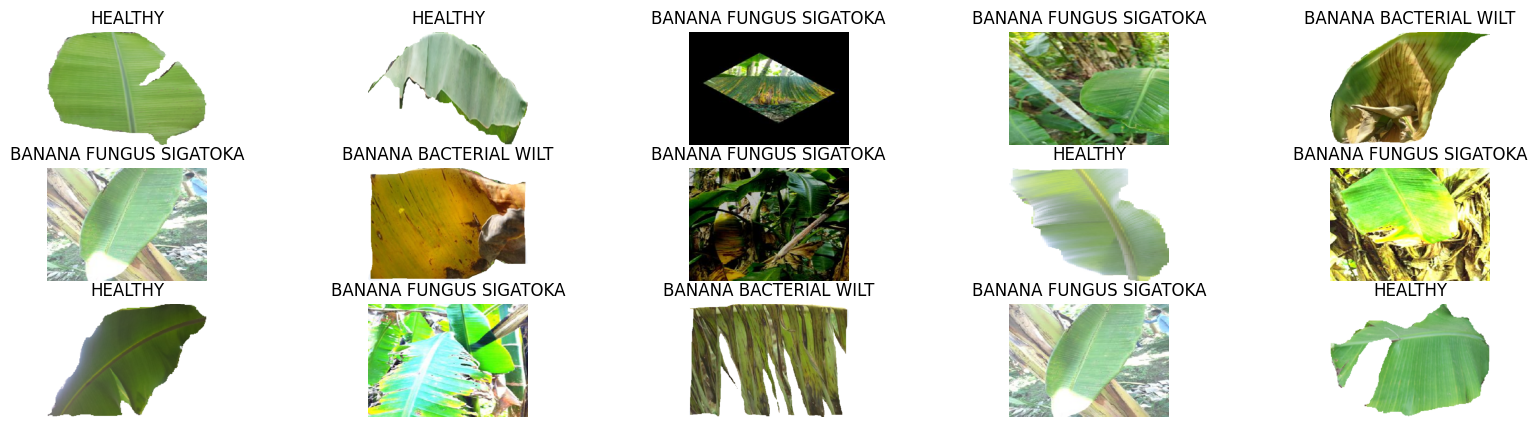

In [6]:
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])

In [7]:
# Fist Model Build
first_model = Sequential([
  Conv2D(8, 2, padding='same', activation='relu', input_shape = image_shape),
  MaxPooling2D(2),
  Conv2D(16, 2, padding='same', activation='relu'),
  MaxPooling2D(2),

  Dropout(0.4),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(4, activation='softmax')
])
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 76, 107, 16)       0         
                                                                 
 flatten (Flatten)           (None, 130112)            0

In [8]:
# Training the Model
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = first_model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 80,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.0796 - acc: 0.5219
Epoch 1: val_loss improved from inf to 1.22469, saving model to chestmodel.hdf5
20/20 [==============================] - 33s 2s/step - loss: 1.0796 - acc: 0.5219 - val_loss: 1.2247 - val_acc: 0.4643
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 0.8221 - acc: 0.6562
Epoch 2: val_loss improved from 1.22469 to 0.94575, saving model to chestmodel.hdf5
20/20 [==============================] - 31s 2s/step - loss: 0.8221 - acc: 0.6562 - val_loss: 0.9457 - val_acc: 0.6607
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 0.8159 - acc: 0.6578
Epoch 3: val_loss improved from 0.94575 to 0.87507, saving model to chestmodel.hdf5
20/20 [==============================] - 31s 2s/step - loss: 0.8159 - acc: 0.6578 - val_loss: 0.8751 - val_acc: 0.6607
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 0.6989 - acc: 0.7047
Epoch 4: val_loss improved from 0.87507

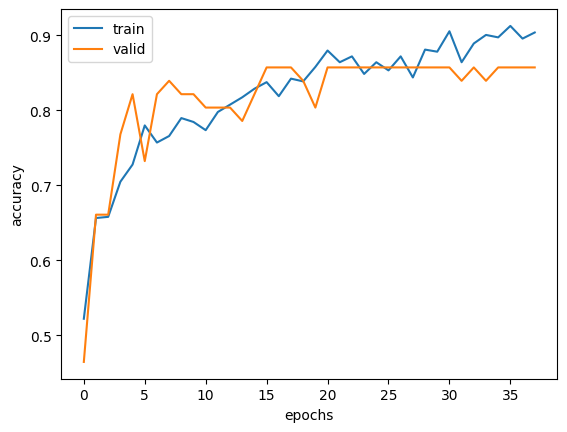

In [11]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [12]:
result  = first_model.evaluate(test_generator)

19/19 [==============================] - 10s 535ms/step - loss: 0.1610 - acc: 0.9586


In [ ]:

Fungi_Net  = FungiNet_model.evaluate(test_generator)

In [13]:
# Transfer Learning
# DEnseNet 201
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 1797 images belonging to 4 classes.
Found 56 images belonging to 4 classes.
Found 604 images belonging to 4 classes.


In [14]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [15]:
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


In [16]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [17]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 5, #80
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 0.9826 - acc: 0.6031 
Epoch 1: val_loss improved from inf to 1.12921, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 738s 36s/step - loss: 0.9826 - acc: 0.6031 - val_loss: 1.1292 - val_acc: 0.5357
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.4076 - acc: 0.9021 
Epoch 2: val_loss improved from 1.12921 to 0.88273, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 691s 35s/step - loss: 0.4076 - acc: 0.9021 - val_loss: 0.8827 - val_acc: 0.7857
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.2886 - acc: 0.9328 
Epoch 3: val_loss improved from 0.88273 to 0.70864, saving model to .\chestmodel-DenseNet201.hdf5
20/20 [==============================] - 724s 36s/step - loss: 0.2886 - acc: 0.9328 - val_loss: 0.7086 - val_acc: 0.8214
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.2077 - acc:

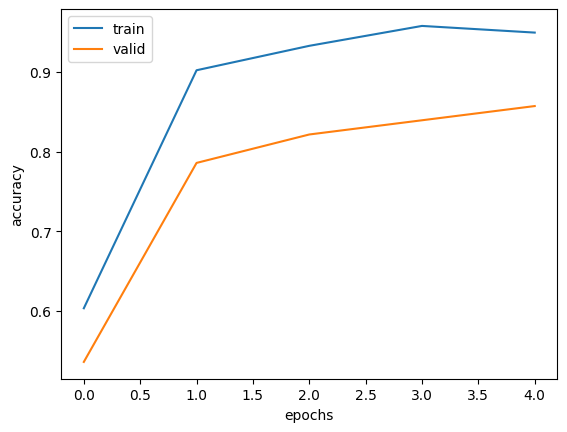

In [18]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [19]:
dns_result  = densenet_model.evaluate(test_generator) 

19/19 [==============================] - 472s 25s/step - loss: 0.3251 - acc: 0.9669


In [ ]:
#virus_Net = virus_model.evaluate(test_generator)

In [ ]:
# ResNet50 dns_result = densenet_model.evaluate(test_generator)

In [ ]:
#eFFICIENT mODEL

In [20]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

NameError: name 'efficientnet' is not defined

In [ ]:
#Model One

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set up the data generators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 38, activation = 'softmax'))

# compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train the model
model.fit(training_set,
          steps_per_epoch = len(training_set),
          epochs = 10,
          validation_data = test_set,
          validation_steps = len(test_set))

# evaluate the model
model.evaluate(test_set, steps = len(test_set))


In [ ]:
# Model Two

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split



In [2]:
# Define function to read image and convert it to grayscale
def read_and_gray_scale_image(file_path):
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img


# Define function to read images from a directory and create a pandas DataFrame
def create_dataframe_from_directory(dir_path):
    data = []
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(dir_path, file_name)
            label = file_name.split('_')[0]
            gray_img = read_and_gray_scale_image(file_path)
            data.append({'image': gray_img.flatten(), 'label': label})
    df = pd.DataFrame(data)
    return df



In [ ]:
# Load images from directories for diseased and healthy plants and combine them into one DataFrame
disease_df = create_dataframe_from_directory('disease_images')
healthy_df = create_dataframe_from_directory('healthy_images')
df = pd.concat([disease_df, healthy_df], ignore_index=True)



In [ ]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)



In [ ]:
# Define KNN classifier and fit the training data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(list(X_train), y_train)


In [ ]:

# Evaluate the model on the testing data
accuracy = knn.score(list(X_test), y_test)
print('Accuracy:', accuracy)
